In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")


## Reading Data

In [2]:
# !unzip A1Benchmark -d A1Benchmark

In [3]:
# Assuming all CSV files are in a folder named 'data'
data_folder = '/content/A1Benchmark/A1Benchmark'
files = os.listdir(data_folder)

# Combine all data into a single dataframe
df = pd.DataFrame()
for file in files:
    if file.endswith('.csv'):
        temp_df = pd.read_csv(os.path.join(data_folder, file))
        df = pd.concat([df, temp_df], ignore_index=True)


## Data Exploration

In [4]:
df.head()

,timestamp,value,is_anomaly
0,1,0.0,0
1,2,101.0,0
2,3,1828.0,0
3,4,1822.0,0
4,5,1918.0,0


### Data Statistics

In [5]:
df.describe()

,timestamp,value,is_anomaly
count,94866.000000,9.486600e+04,94866.000000
mean,713.461883,1.003524e+05,0.017593
std,414.700963,7.212159e+05,0.131468
min,1.000000,0.000000e+00,0.000000
25%,354.000000,4.000000e+00,0.000000
50%,708.000000,6.200000e+01,0.000000
75%,1072.000000,2.127000e+03,0.000000
max,1461.000000,7.845760e+06,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94866 entries, 0 to 94865
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   94866 non-null  int64  
 1   value       94866 non-null  float64
 2   is_anomaly  94866 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.2 MB


### Checking if any missing values in the dataset

In [7]:
df.isna().sum()

timestamp     0
value         0
is_anomaly    0
dtype: int64

### Data Visualization

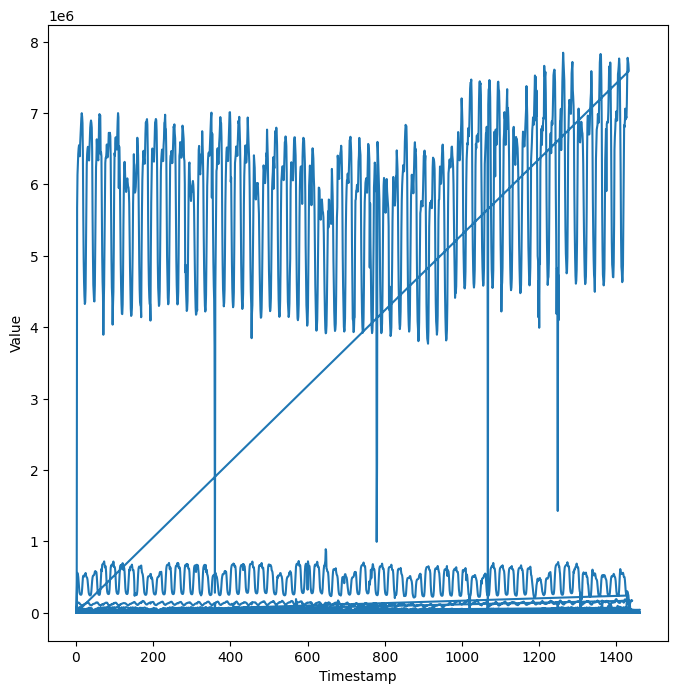

In [8]:
# Visualizing different values of the different timestamp
plt.figure(figsize=(8, 8))
plt.plot(df['timestamp'], df['value'])
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

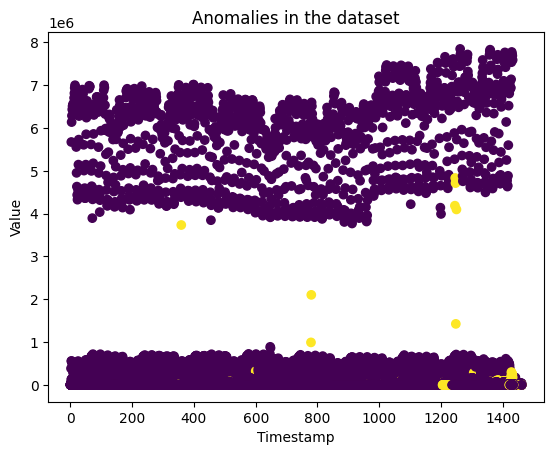

In [9]:
# Scatter plot for visualizing the normal and anomaly data with thier values
plt.scatter(df['timestamp'], df['value'], c=df['is_anomaly'])
plt.title('Anomalies in the dataset')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

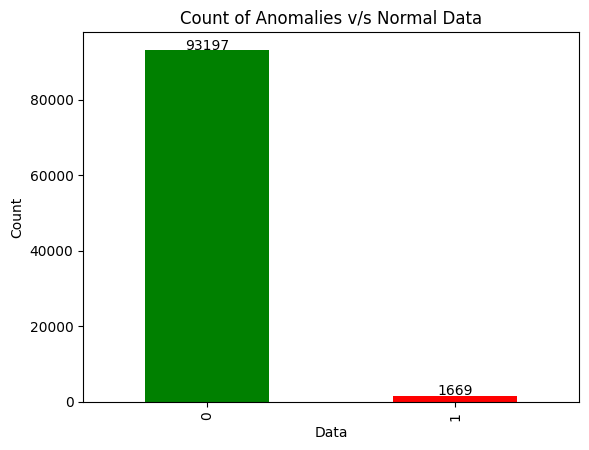

In [10]:
# Number of Anomalies and Normal data in the dataset
anomalies = df['is_anomaly'].value_counts()

anomalies.plot(kind='bar', color=['green', 'red'])
plt.title('Count of Anomalies v/s Normal Data')
plt.xlabel('Data')
plt.ylabel('Count')

total_count = anomalies.sum()
for i, count in enumerate(anomalies):
    plt.text(i, count + 100, f'{count}', ha='center')

plt.show()

## Data Preprocessing

### Normalization

In [11]:
X = df[['timestamp', 'value']].values
Y = df['is_anomaly'].values

# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Splitting the dataset into Training, Test and Validation sets

In [12]:
# Split data into training, validation, and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_validation, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_validation, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}\n')

print(f'X_validation shape: {X_validation.shape}' )
print(f'Y_validation shape: {Y_validation.shape}\n')


X_train shape: (60713, 2)
Y_train shape: (60713,)

X_test shape: (18974, 2)
Y_test shape: (18974,)

X_validation shape: (15179, 2)
Y_validation shape: (15179,)



## Functions to calculate the threshold value

In [13]:
def find_threshold(model, X_train_tensor):
    with torch.no_grad():
        reconstructions = model(torch.tensor(X_train_tensor, dtype=torch.float32))
        reconstruction_errors = torch.mean((reconstructions - torch.tensor(X_train_tensor, dtype=torch.float32)) ** 2, dim=1)
        threshold = np.percentile(reconstruction_errors.numpy(), 95)
    return threshold

def predictions(model, X_train_tensor, threshold):
    with torch.no_grad():
        predictions = model(torch.tensor(X_train_tensor, dtype=torch.float32))
        errors = torch.mean((predictions - torch.tensor(X_train_tensor, dtype=torch.float32)) ** 2, dim=1)
        anomaly_mask = errors > threshold
        preds = anomaly_mask.type(torch.float32)
    return preds.numpy()

# Autoencoder Model Building

## Model 1

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
input_dim = X_train.shape[1]
hidden_dim = 64
AE_model = AutoEncoder(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(AE_model.parameters(), lr=0.001)

In [16]:
train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []

epochs = 50

for epoch in range(epochs):
    AE_model.train()
    train_loss = 0
    train_r2_sum = 0

    optimizer.zero_grad()

    # Forward pass
    train_reconstruction = AE_model(X_train_tensor)

    # Compute loss
    loss = criterion(train_reconstruction, X_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    training_loss = loss.item()
    training_r2_score = r2_score(X_train_tensor.detach().numpy(), train_reconstruction.detach().numpy())

    train_losses.append(training_loss)
    train_accuracies.append(training_r2_score*100)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {training_loss:.4f}, Train Accuracy: {training_r2_score*100:.3f}%')

    with torch.no_grad():
        val_loss = 0
        val_r2_sum = 0
        AE_model.eval()

        output_val = AE_model(X_val_tensor)

        val_loss = criterion(output_val, X_val_tensor).item()
        val_r2_sum = r2_score(X_val_tensor.detach().numpy(), output_val.detach().numpy())

    validation_loss = val_loss
    validation_losses.append(validation_loss)

    validation_r2_score = val_r2_sum
    validation_accuracies.append(validation_r2_score*100)

    print(f'\t\tValidation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_r2_score*100:.3f}%')

torch.save(AE_model.state_dict(), "shivanma_assignment2_model_1.pth")

Epoch [1/50], Train Loss: 0.9759, Train Accuracy: -0.017%
		Validation Loss: 1.0307, Validation Accuracy: 0.702%
Epoch [2/50], Train Loss: 0.9682, Train Accuracy: 0.772%
		Validation Loss: 1.0227, Validation Accuracy: 1.463%
Epoch [3/50], Train Loss: 0.9609, Train Accuracy: 1.531%
		Validation Loss: 1.0157, Validation Accuracy: 2.131%
Epoch [4/50], Train Loss: 0.9544, Train Accuracy: 2.198%
		Validation Loss: 1.0088, Validation Accuracy: 2.800%
Epoch [5/50], Train Loss: 0.9479, Train Accuracy: 2.861%
		Validation Loss: 1.0011, Validation Accuracy: 3.533%
Epoch [6/50], Train Loss: 0.9408, Train Accuracy: 3.591%
		Validation Loss: 0.9931, Validation Accuracy: 4.298%
Epoch [7/50], Train Loss: 0.9334, Train Accuracy: 4.351%
		Validation Loss: 0.9845, Validation Accuracy: 5.127%
Epoch [8/50], Train Loss: 0.9254, Train Accuracy: 5.175%
		Validation Loss: 0.9749, Validation Accuracy: 6.041%
Epoch [9/50], Train Loss: 0.9166, Train Accuracy: 6.086%
		Validation Loss: 0.9644, Validation Accuracy

<Figure size 640x480 with 0 Axes>

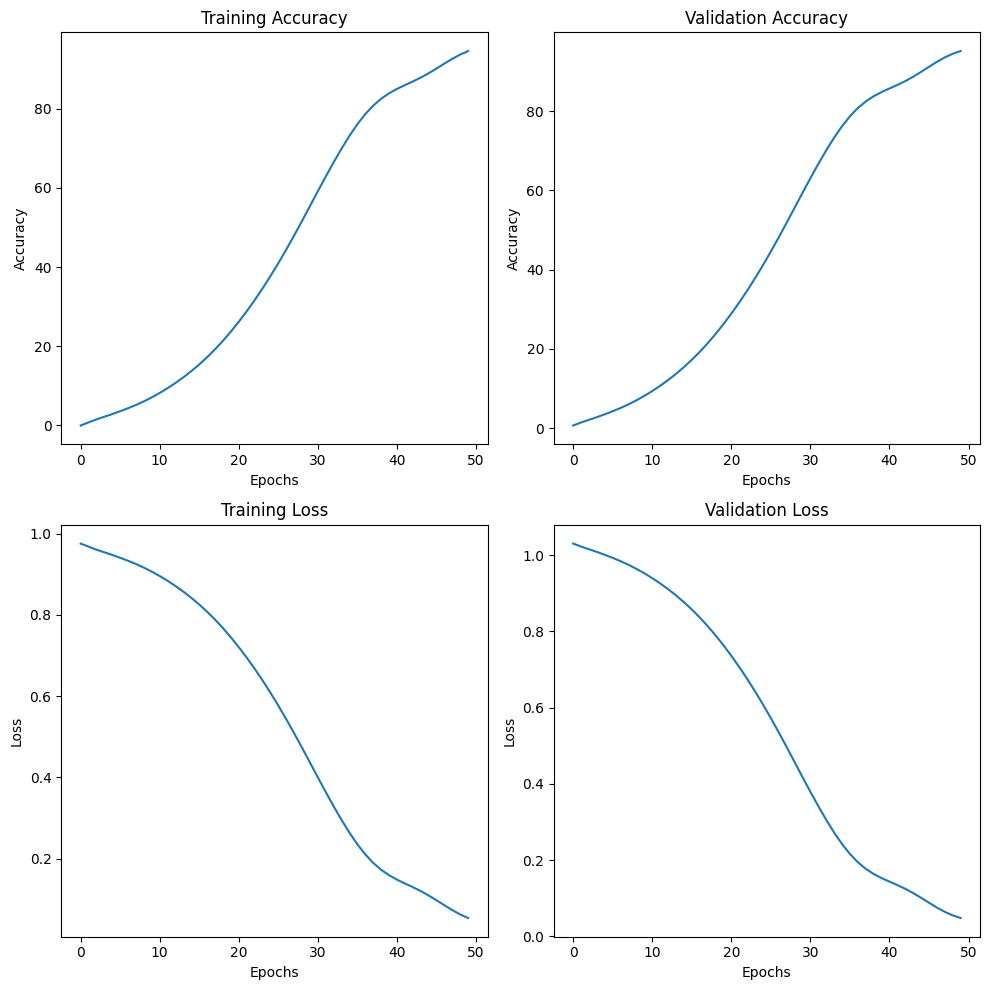

In [17]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [18]:
test_predictions = []

with torch.no_grad():
    test_loss = 0
    test_r2_sum = 0
    AE_model.eval()

    output_test = AE_model(X_test_tensor)
    test_predictions.append(output_test.detach().numpy())

    test_loss = criterion(output_test, X_test_tensor).item()
    test_r2_sum = r2_score(X_test_tensor.detach().numpy(), output_test.detach().numpy())

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_r2_sum*100:.3f}%')

Test Loss: 0.0482, Test Accuracy: 95.266%


In [19]:
print(f"Training Accuracy: {training_r2_score*100:.4f}, Training Loss: {training_loss:.4f}")
print(f"Validation Accuracy: {validation_r2_score*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_r2_sum*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 94.5804, Training Loss: 0.0538
Validation Accuracy: 95.1560, Validation Loss: 0.0485
Testing Accuracy: 95.2663, Testing Loss: 0.0482


In [20]:
threshold = find_threshold(AE_model, X_train_tensor)
print(f"Threshold: {threshold}")

Threshold: 0.238430643081665


In [21]:
preds = predictions(AE_model, X_test_tensor, threshold)

# Evaluation
accuracy_test = accuracy_score(preds, Y_test_tensor) * 100
precision_test = precision_score(preds, Y_test_tensor, average='micro')
recall_test = recall_score(preds, Y_test_tensor, average='macro')
f1_test = f1_score(preds, Y_test_tensor, average='macro')
confusion_matrix_test = confusion_matrix(preds, Y_test_tensor)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Accuracy: 93.075
Precision: 0.931
Recall: 0.492
F1 score: 0.484

Confusion Matrix: 
 [[17658   342]
 [  972     2]]


## Model 2

In [22]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMAutoEncoder, self).__init__()

        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.decoder(x)
        return x

In [23]:
input_size = X_train.shape[1]
hidden_dim = 64
AE_model_2 = LSTMAutoEncoder(input_size, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(AE_model_2.parameters(), lr=0.001)

In [24]:
train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []

epochs = 50

for epoch in range(epochs):
    AE_model_2.train()
    train_loss = 0
    train_r2_sum = 0

    optimizer.zero_grad()

    # Forward pass
    train_reconstruction = AE_model_2(X_train_tensor)

    # Compute loss
    loss = criterion(train_reconstruction, X_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    training_loss = loss.item()
    training_r2_score = r2_score(X_train_tensor.detach().numpy(), train_reconstruction.detach().numpy())

    train_losses.append(training_loss)
    train_accuracies.append(training_r2_score*100)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {training_loss:.4f}, Train Accuracy: {training_r2_score*100:.3f}%')

    with torch.no_grad():
        val_loss = 0
        val_r2_sum = 0
        AE_model_2.eval()

        output_val = AE_model_2(X_val_tensor)

        val_loss = criterion(output_val, X_val_tensor).item()
        val_r2_sum = r2_score(X_val_tensor.detach().numpy(), output_val.detach().numpy())

    validation_loss = val_loss
    validation_losses.append(validation_loss)

    validation_r2_score = val_r2_sum
    validation_accuracies.append(validation_r2_score*100)

    print(f'\t\tValidation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_r2_score*100:.3f}%')

torch.save(AE_model_2.state_dict(), "shivanma_assignment2_model_2.pth")

Epoch [1/50], Train Loss: 0.9878, Train Accuracy: -1.168%
		Validation Loss: 1.0448, Validation Accuracy: -0.773%
Epoch [2/50], Train Loss: 0.9839, Train Accuracy: -0.772%
		Validation Loss: 1.0410, Validation Accuracy: -0.402%
Epoch [3/50], Train Loss: 0.9802, Train Accuracy: -0.396%
		Validation Loss: 1.0374, Validation Accuracy: -0.048%
Epoch [4/50], Train Loss: 0.9767, Train Accuracy: -0.038%
		Validation Loss: 1.0340, Validation Accuracy: 0.291%
Epoch [5/50], Train Loss: 0.9733, Train Accuracy: 0.305%
		Validation Loss: 1.0306, Validation Accuracy: 0.614%
Epoch [6/50], Train Loss: 0.9701, Train Accuracy: 0.633%
		Validation Loss: 1.0275, Validation Accuracy: 0.924%
Epoch [7/50], Train Loss: 0.9670, Train Accuracy: 0.947%
		Validation Loss: 1.0244, Validation Accuracy: 1.221%
Epoch [8/50], Train Loss: 0.9640, Train Accuracy: 1.248%
		Validation Loss: 1.0214, Validation Accuracy: 1.508%
Epoch [9/50], Train Loss: 0.9612, Train Accuracy: 1.540%
		Validation Loss: 1.0186, Validation Ac

<Figure size 640x480 with 0 Axes>

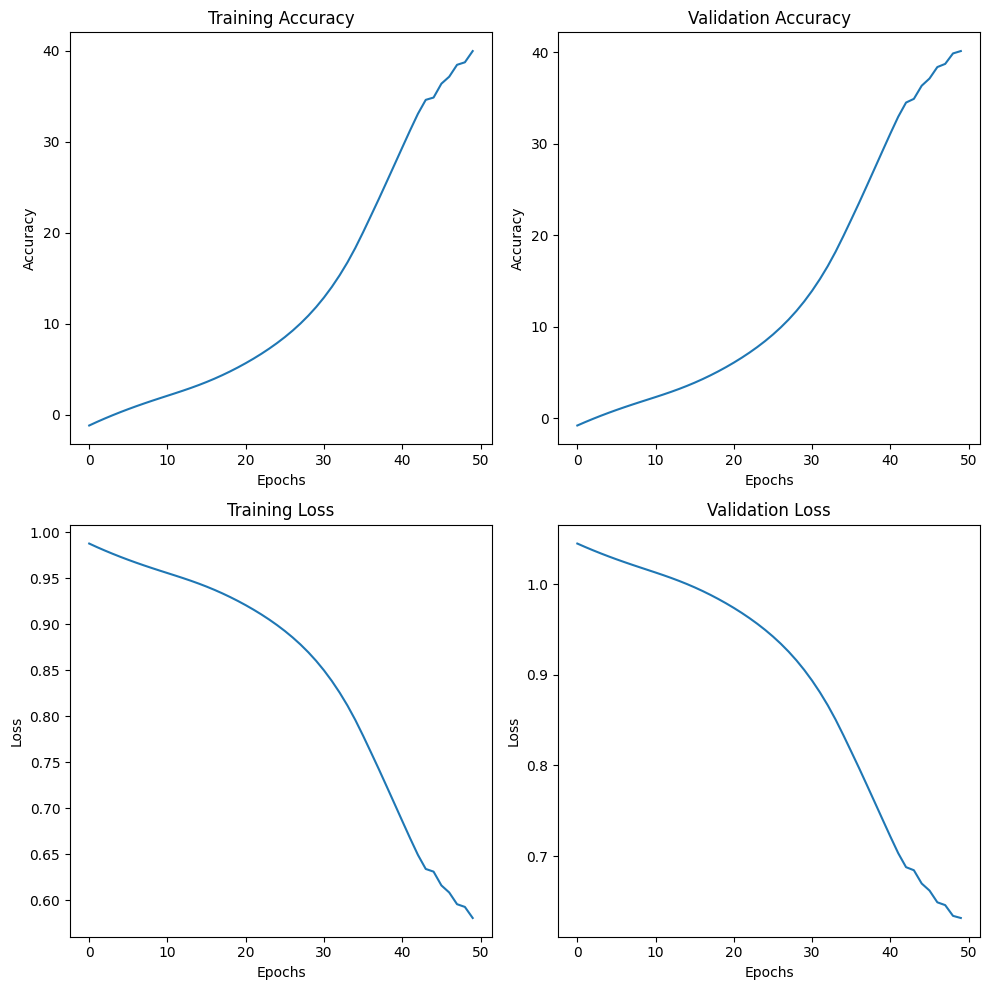

In [25]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [26]:
test_predictions = []

with torch.no_grad():
    test_loss = 0
    test_r2_sum = 0
    AE_model_2.eval()

    output_test = AE_model_2(X_test_tensor)
    test_predictions.append(output_test.detach().numpy())

    test_loss = criterion(output_test, X_test_tensor).item()
    test_r2_sum = r2_score(X_test_tensor.detach().numpy(), output_test.detach().numpy())

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_r2_sum*100:.3f}%')

Test Loss: 0.6367, Test Accuracy: 40.028%


In [27]:
print(f"Training Accuracy: {training_r2_score*100:.4f}, Training Loss: {training_loss:.4f}")
print(f"Validation Accuracy: {validation_r2_score*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_r2_sum*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 39.9759, Training Loss: 0.5805
Validation Accuracy: 40.1575, Validation Loss: 0.6318
Testing Accuracy: 40.0277, Testing Loss: 0.6367


In [28]:
threshold = find_threshold(AE_model_2, X_train_tensor)
print(f"Threshold: {threshold}")

preds = predictions(AE_model_2, X_test_tensor, threshold)

# Evaluation
accuracy_test = accuracy_score(preds, Y_test_tensor) * 100
precision_test = precision_score(preds, Y_test_tensor, average='micro')
recall_test = recall_score(preds, Y_test_tensor, average='macro')
f1_test = f1_score(preds, Y_test_tensor, average='macro')
confusion_matrix_test = confusion_matrix(preds, Y_test_tensor)

print(f'\nAccuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Threshold: 0.5814184188842769

Accuracy: 93.602
Precision: 0.936
Recall: 0.520
F1 score: 0.525

Confusion Matrix: 
 [[17705   289]
 [  925    55]]


## Model 3

In [29]:
class AutoEncoder_3(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder_3, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),  # Changed ReLU to Tanh
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),  # Changed ReLU to Tanh
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),  # Changed ReLU to Tanh
            nn.Linear(64, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [30]:
input_size = 2
hidden_dim = 128 # Increased the number of hidden units
AE_model_3 = AutoEncoder_3(input_size, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(AE_model_3.parameters(), lr=0.001)

In [31]:
train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []

epochs = 50

for epoch in range(epochs):
    AE_model_3.train()
    train_loss = 0
    train_r2_sum = 0

    optimizer.zero_grad()

    # Forward pass
    train_reconstruction = AE_model_3(X_train_tensor)

    # Compute loss
    loss = criterion(train_reconstruction, X_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    training_loss = loss.item()
    training_r2_score = r2_score(X_train_tensor.detach().numpy(), train_reconstruction.detach().numpy())

    train_losses.append(training_loss)
    train_accuracies.append(training_r2_score*100)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {training_loss:.4f}, Train Accuracy: {training_r2_score*100:.3f}%')

    with torch.no_grad():
        val_loss = 0
        val_r2_sum = 0
        AE_model_3.eval()

        output_val = AE_model_3(X_val_tensor)

        val_loss = criterion(output_val, X_val_tensor).item()
        val_r2_sum = r2_score(X_val_tensor.detach().numpy(), output_val.detach().numpy())

    validation_loss = val_loss
    validation_losses.append(validation_loss)

    validation_r2_score = val_r2_sum
    validation_accuracies.append(validation_r2_score*100)

    print(f'\t\tValidation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_r2_score*100:.3f}%')

torch.save(AE_model_3.state_dict(), "shivanma_assignment2_model_3.pth")

Epoch [1/50], Train Loss: 0.9847, Train Accuracy: -0.915%
		Validation Loss: 1.0272, Validation Accuracy: 1.041%
Epoch [2/50], Train Loss: 0.9663, Train Accuracy: 0.968%
		Validation Loss: 1.0109, Validation Accuracy: 2.655%
Epoch [3/50], Train Loss: 0.9494, Train Accuracy: 2.679%
		Validation Loss: 0.9904, Validation Accuracy: 4.709%
Epoch [4/50], Train Loss: 0.9284, Train Accuracy: 4.785%
		Validation Loss: 0.9619, Validation Accuracy: 7.556%
Epoch [5/50], Train Loss: 0.8998, Train Accuracy: 7.660%
		Validation Loss: 0.9239, Validation Accuracy: 11.363%
Epoch [6/50], Train Loss: 0.8617, Train Accuracy: 11.485%
		Validation Loss: 0.8759, Validation Accuracy: 16.177%
Epoch [7/50], Train Loss: 0.8136, Train Accuracy: 16.310%
		Validation Loss: 0.8185, Validation Accuracy: 21.934%
Epoch [8/50], Train Loss: 0.7562, Train Accuracy: 22.074%
		Validation Loss: 0.7538, Validation Accuracy: 28.428%
Epoch [9/50], Train Loss: 0.6915, Train Accuracy: 28.569%
		Validation Loss: 0.6858, Validation 

<Figure size 640x480 with 0 Axes>

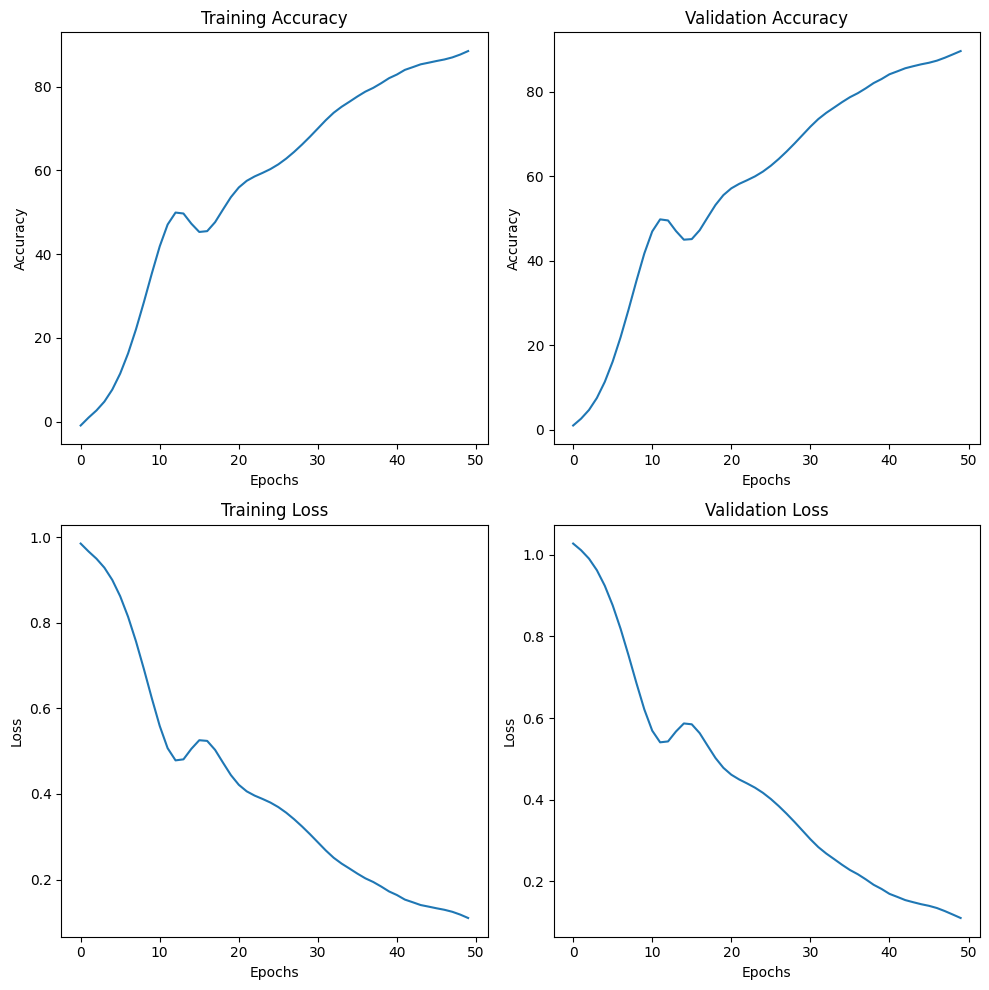

In [32]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [33]:
test_predictions = []

with torch.no_grad():
    test_loss = 0
    test_r2_sum = 0
    AE_model_3.eval()

    output_test = AE_model_3(X_test_tensor)
    test_predictions.append(output_test.detach().numpy())

    test_loss = criterion(output_test, X_test_tensor).item()
    test_r2_sum = r2_score(X_test_tensor.detach().numpy(), output_test.detach().numpy())


print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_r2_sum*100:.3f}%')

Test Loss: 0.1136, Test Accuracy: 89.396%


In [34]:
print(f"Training Accuracy: {training_r2_score*100:.4f}, Training Loss: {training_loss:.4f}")
print(f"Validation Accuracy: {validation_r2_score*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_r2_sum*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 88.5048, Training Loss: 0.1104
Validation Accuracy: 89.6293, Validation Loss: 0.1106
Testing Accuracy: 89.3964, Testing Loss: 0.1136


In [35]:
threshold = find_threshold(AE_model_3, X_train_tensor)
print(f"Threshold: {threshold}")

preds = predictions(AE_model_3, X_test_tensor, threshold)

# Evaluation
accuracy_test = accuracy_score(preds, Y_test_tensor) * 100
precision_test = precision_score(preds, Y_test_tensor, average='micro')
recall_test = recall_score(preds, Y_test_tensor, average='macro')
f1_test = f1_score(preds, Y_test_tensor, average='macro')
confusion_matrix_test = confusion_matrix(preds, Y_test_tensor)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Threshold: 0.07648282647132873
Accuracy: 93.412
Precision: 0.934
Recall: 0.504
F1 score: 0.501

Confusion Matrix: 
 [[17700   320]
 [  930    24]]


## Model 4

In [36]:
class AutoEncoder_4(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder_4, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),  # Changed Tanh to LeakyReLU
            nn.Dropout(0.2), # Added Dropout
            nn.Linear(hidden_dim, 64),
            nn.LeakyReLU(),  # Changed Tanh to LeakyReLU
            nn.Linear(64, 32),
            nn.LeakyReLU(), # Changed Tanh to LeakyReLU
            nn.Dropout(0.2), # Added Dropout
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.LeakyReLU(), # Changed Tanh to LeakyReLU
            nn.Dropout(0.2), # Added Dropout
            nn.Linear(32, 64),
            nn.LeakyReLU(),  # Changed Tanh to LeakyReLU
            nn.Linear(64, hidden_dim),
            nn.LeakyReLU(),  # Changed Tanh to LeakyReLU
            nn.Dropout(0.2), # Added Dropout
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
input_size = X_train.shape[1]
hidden_dim = 128
AE_model_4 = AutoEncoder_4(input_size, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(AE_model_4.parameters(), lr=0.001)

In [38]:
train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []

epochs = 50

for epoch in range(epochs):
    AE_model_4.train()
    train_loss = 0
    train_r2_sum = 0

    optimizer.zero_grad()

    # Forward pass
    train_reconstruction = AE_model_4(X_train_tensor)

    # Compute loss
    loss = criterion(train_reconstruction, X_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    training_loss = loss.item()
    training_r2_score = r2_score(X_train_tensor.detach().numpy(), train_reconstruction.detach().numpy())

    train_losses.append(training_loss)
    train_accuracies.append(training_r2_score*100)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {training_loss:.4f}, Train Accuracy: {training_r2_score*100:.3f}%')

    with torch.no_grad():
        val_loss = 0
        val_r2_sum = 0
        AE_model_4.eval()

        output_val = AE_model_4(X_val_tensor)

        val_loss = criterion(output_val, X_val_tensor).item()
        val_r2_sum = r2_score(X_val_tensor.detach().numpy(), output_val.detach().numpy())

    validation_loss = val_loss
    validation_losses.append(validation_loss)

    validation_r2_score = val_r2_sum
    validation_accuracies.append(validation_r2_score*100)

    print(f'\t\tValidation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_r2_score*100:.3f}%')

torch.save(AE_model_4.state_dict(), "shivanma_assignment2_model_4.pth")

Epoch [1/50], Train Loss: 0.9792, Train Accuracy: -0.331%
		Validation Loss: 1.0372, Validation Accuracy: 0.035%
Epoch [2/50], Train Loss: 0.9759, Train Accuracy: 0.012%
		Validation Loss: 1.0336, Validation Accuracy: 0.375%
Epoch [3/50], Train Loss: 0.9727, Train Accuracy: 0.343%
		Validation Loss: 1.0299, Validation Accuracy: 0.734%
Epoch [4/50], Train Loss: 0.9690, Train Accuracy: 0.718%
		Validation Loss: 1.0258, Validation Accuracy: 1.127%
Epoch [5/50], Train Loss: 0.9655, Train Accuracy: 1.077%
		Validation Loss: 1.0208, Validation Accuracy: 1.602%
Epoch [6/50], Train Loss: 0.9607, Train Accuracy: 1.579%
		Validation Loss: 1.0142, Validation Accuracy: 2.224%
Epoch [7/50], Train Loss: 0.9544, Train Accuracy: 2.231%
		Validation Loss: 1.0054, Validation Accuracy: 3.068%
Epoch [8/50], Train Loss: 0.9465, Train Accuracy: 3.039%
		Validation Loss: 0.9939, Validation Accuracy: 4.155%
Epoch [9/50], Train Loss: 0.9370, Train Accuracy: 4.023%
		Validation Loss: 0.9801, Validation Accuracy

<Figure size 640x480 with 0 Axes>

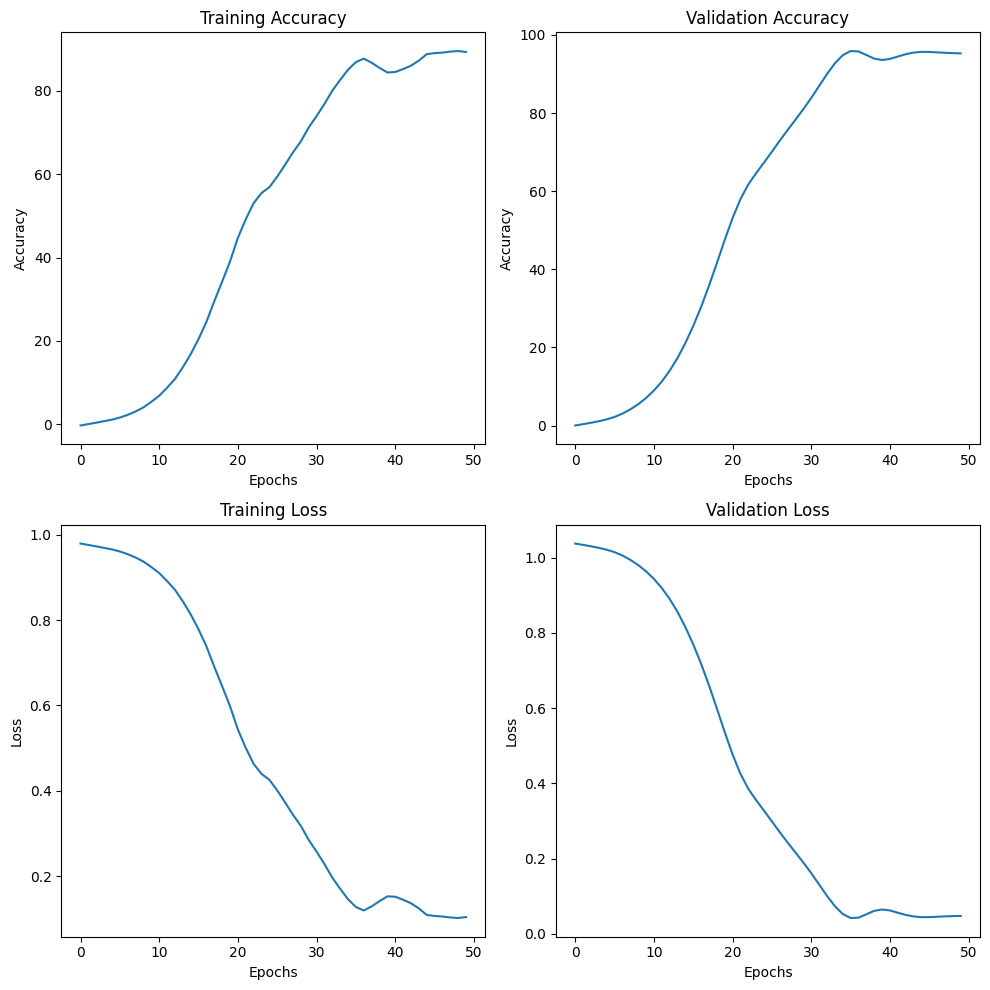

In [39]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [40]:
test_predictions = []

with torch.no_grad():
    test_loss = 0
    test_r2_sum = 0
    AE_model_4.eval()

    output_test = AE_model_4(X_test_tensor)
    test_predictions.append(output_test.detach().numpy())

    test_loss = criterion(output_test, X_test_tensor).item()
    test_r2_sum = r2_score(X_test_tensor.detach().numpy(), output_test.detach().numpy())


print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_r2_sum*100:.3f}%')

Test Loss: 0.0471, Test Accuracy: 95.389%


In [41]:
print(f"Training Accuracy: {training_r2_score*100:.4f}, Training Loss: {training_loss:.4f}")
print(f"Validation Accuracy: {validation_r2_score*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_r2_sum*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 89.3521, Training Loss: 0.1045
Validation Accuracy: 95.2788, Validation Loss: 0.0475
Testing Accuracy: 95.3889, Testing Loss: 0.0471


In [42]:
threshold = find_threshold(AE_model_4, X_train_tensor)
print(f"Threshold: {threshold}")

preds = predictions(AE_model_4, X_test_tensor, threshold)

# Evaluation
accuracy_test = accuracy_score(preds, Y_test_tensor) * 100
precision_test = precision_score(preds, Y_test_tensor, average='micro')
recall_test = recall_score(preds, Y_test_tensor, average='macro')
f1_test = f1_score(preds, Y_test_tensor, average='macro')
confusion_matrix_test = confusion_matrix(preds, Y_test_tensor)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Threshold: 0.1550538212060928
Accuracy: 93.054
Precision: 0.931
Recall: 0.493
F1 score: 0.486

Confusion Matrix: 
 [[17651   339]
 [  979     5]]
